# 1. RNN을 이용하여 텍스트 생성하기

In [1]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, SimpleRNN,Flatten


In [2]:
text = """
동해 물과 백두산이 마르고 닳도록 하느님이 보우하사 우리나라 만세
무궁화 삼천리 화려강산 대한 사람 대한으로 길이 보전하세
남산 위에 저 소나무 철갑을 두른 듯 바람 서리 불변함은 우리 기상일세
무궁화 삼천리 화려강산 대한 사람 대한으로 길이 보전하세
"""

In [3]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts([text])
print(tokenizer)

In [4]:
vocab_size = len(tokenizer.word_index) + 1
print('단어 집합의 크기 : %d' % vocab_size)

단어 집합의 크기 : 30


In [5]:
token_list = tokenizer.texts_to_sequences([text])[0]   # [0]을 붙여야 리스트 내부의 리스트를 꺼냄
print('token_list:', token_list)

token_list: [9, 10, 11, 12, 13, 14, 15, 16, 17, 1, 2, 3, 4, 5, 6, 7, 8, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 1, 2, 3, 4, 5, 6, 7, 8]


In [6]:
print(tokenizer.word_index)

{'무궁화': 1, '삼천리': 2, '화려강산': 3, '대한': 4, '사람': 5, '대한으로': 6, '길이': 7, '보전하세': 8, '동해': 9, '물과': 10, '백두산이': 11, '마르고': 12, '닳도록': 13, '하느님이': 14, '보우하사': 15, '우리나라': 16, '만세': 17, '남산': 18, '위에': 19, '저': 20, '소나무': 21, '철갑을': 22, '두른': 23, '듯': 24, '바람': 25, '서리': 26, '불변함은': 27, '우리': 28, '기상일세': 29}


In [7]:
#  Sliding window 기반 X, y 생성
def create_xy_sliding(token_list, max_len, vocab_size):
    input_sequences = []
    for i in range(max_len, len(token_list)):
        input_sequences.append(token_list[i - max_len:i + 1])

    input_sequences = np.array(input_sequences)
    print("\n sliding sequences:\n", input_sequences)
    
    X = input_sequences[:, :-1]
    y = to_categorical(input_sequences[:, -1], num_classes=vocab_size)
    print("\nsliding X:\n", X)
    print("\nsliding y:\n",y)
    return X, y

In [8]:
# 문장 단위 n-gram 기반 X, y 생성
def create_xy_ngram(text, tokenizer, vocab_size):
    sequences = []
    for line in text.split('\n'):
        encoded = tokenizer.texts_to_sequences([line])[0]
        for i in range(1, len(encoded)):
            sequence = encoded[:i + 1]
            sequences.append(sequence)

    max_len = max(len(seq) for seq in sequences)
    sequences = pad_sequences(sequences, maxlen=max_len, padding='pre')
    sequences = np.array(sequences)
    
    print("\n n-gram sequences:\n", sequences)

    X = sequences[:, :-1]
    y = to_categorical(sequences[:, -1], num_classes=vocab_size)
    print("\nn-gram X:\n", X)
    print("\nn-gram y:\n",y)
    return X, y

In [9]:
embedding_dim = 20
hidden_units = 32
dnn_units = 16
max_len = 15

In [10]:
def build_model(input_length, vocab_size):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim),
        SimpleRNN(hidden_units),
        Dense(dnn_units, activation='relu'),
        Dense(vocab_size, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['mse'])
    return model

def plot_history(history, mode):
    plt.figure(figsize=(7, 5))

    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'Model Loss : mode={mode} ')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(frameon=False,loc='best')  
    plt.tight_layout()
    plt.show()

In [11]:
# Sliding 모델 학습
X_sliding, y_sliding = create_xy_sliding(token_list, max_len, vocab_size)


 sliding sequences:
 [[ 9 10 11 12 13 14 15 16 17  1  2  3  4  5  6  7]
 [10 11 12 13 14 15 16 17  1  2  3  4  5  6  7  8]
 [11 12 13 14 15 16 17  1  2  3  4  5  6  7  8 18]
 [12 13 14 15 16 17  1  2  3  4  5  6  7  8 18 19]
 [13 14 15 16 17  1  2  3  4  5  6  7  8 18 19 20]
 [14 15 16 17  1  2  3  4  5  6  7  8 18 19 20 21]
 [15 16 17  1  2  3  4  5  6  7  8 18 19 20 21 22]
 [16 17  1  2  3  4  5  6  7  8 18 19 20 21 22 23]
 [17  1  2  3  4  5  6  7  8 18 19 20 21 22 23 24]
 [ 1  2  3  4  5  6  7  8 18 19 20 21 22 23 24 25]
 [ 2  3  4  5  6  7  8 18 19 20 21 22 23 24 25 26]
 [ 3  4  5  6  7  8 18 19 20 21 22 23 24 25 26 27]
 [ 4  5  6  7  8 18 19 20 21 22 23 24 25 26 27 28]
 [ 5  6  7  8 18 19 20 21 22 23 24 25 26 27 28 29]
 [ 6  7  8 18 19 20 21 22 23 24 25 26 27 28 29  1]
 [ 7  8 18 19 20 21 22 23 24 25 26 27 28 29  1  2]
 [ 8 18 19 20 21 22 23 24 25 26 27 28 29  1  2  3]
 [18 19 20 21 22 23 24 25 26 27 28 29  1  2  3  4]
 [19 20 21 22 23 24 25 26 27 28 29  1  2  3  4  5]
 [20 21 2

In [12]:
print("X shape:", X_sliding.shape)
print("y shape:", y_sliding.shape)
print("X sample:", X_sliding[0])
print("y sample:", y_sliding[0])

X shape: (22, 15)
y shape: (22, 30)
X sample: [ 9 10 11 12 13 14 15 16 17  1  2  3  4  5  6]
y sample: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]


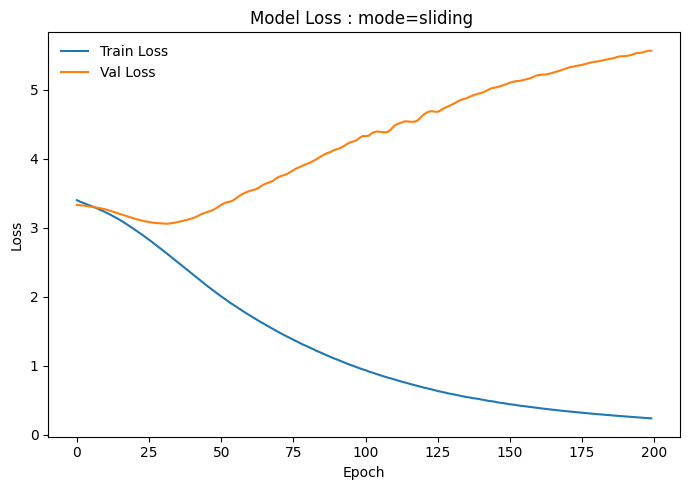

In [13]:
model_sliding = build_model(X_sliding.shape[1], vocab_size)
history_sliding = model_sliding.fit(X_sliding, y_sliding, validation_split=0.2, epochs=200, verbose=0)
plot_history(history_sliding,'sliding')

In [14]:
# Ngram 모델 학습
X_ngram, y_ngram = create_xy_ngram(text, tokenizer, vocab_size)


 n-gram sequences:
 [[ 0  0  0  0  0  0  0  0  0  0  9 10]
 [ 0  0  0  0  0  0  0  0  0  9 10 11]
 [ 0  0  0  0  0  0  0  0  9 10 11 12]
 [ 0  0  0  0  0  0  0  9 10 11 12 13]
 [ 0  0  0  0  0  0  9 10 11 12 13 14]
 [ 0  0  0  0  0  9 10 11 12 13 14 15]
 [ 0  0  0  0  9 10 11 12 13 14 15 16]
 [ 0  0  0  9 10 11 12 13 14 15 16 17]
 [ 0  0  0  0  0  0  0  0  0  0  1  2]
 [ 0  0  0  0  0  0  0  0  0  1  2  3]
 [ 0  0  0  0  0  0  0  0  1  2  3  4]
 [ 0  0  0  0  0  0  0  1  2  3  4  5]
 [ 0  0  0  0  0  0  1  2  3  4  5  6]
 [ 0  0  0  0  0  1  2  3  4  5  6  7]
 [ 0  0  0  0  1  2  3  4  5  6  7  8]
 [ 0  0  0  0  0  0  0  0  0  0 18 19]
 [ 0  0  0  0  0  0  0  0  0 18 19 20]
 [ 0  0  0  0  0  0  0  0 18 19 20 21]
 [ 0  0  0  0  0  0  0 18 19 20 21 22]
 [ 0  0  0  0  0  0 18 19 20 21 22 23]
 [ 0  0  0  0  0 18 19 20 21 22 23 24]
 [ 0  0  0  0 18 19 20 21 22 23 24 25]
 [ 0  0  0 18 19 20 21 22 23 24 25 26]
 [ 0  0 18 19 20 21 22 23 24 25 26 27]
 [ 0 18 19 20 21 22 23 24 25 26 27 28]
 [18

In [15]:
print("X shape:", X_ngram.shape)
print("y shape:", y_ngram.shape)
print("X sample:", X_ngram[0])
print("y sample:", y_ngram[0])

X shape: (33, 11)
y shape: (33, 30)
X sample: [0 0 0 0 0 0 0 0 0 0 9]
y sample: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]


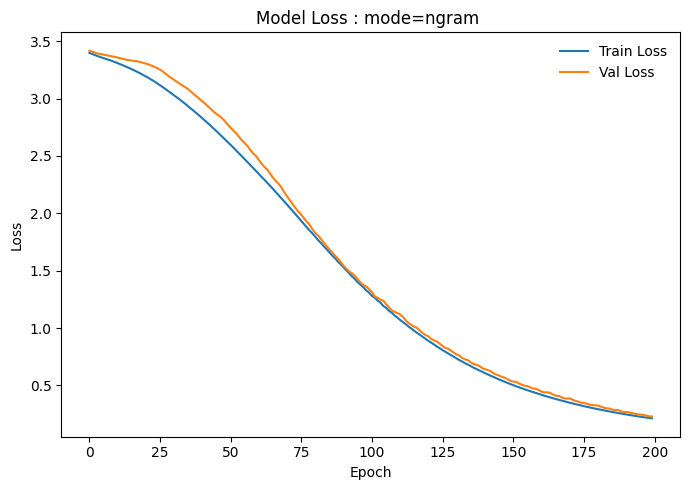

In [16]:
model_ngram = build_model(X_ngram.shape[1], vocab_size)
history_ngram = model_ngram.fit(X_ngram, y_ngram, validation_split=0.2, epochs=200, verbose=0)
plot_history(history_ngram ,'ngram')

In [17]:
# 결과 비교 출력
print(f"Sliding Loss: {history_sliding.history['loss'][-1]:.4f}")
print(f"Ngram Loss: {history_ngram.history['loss'][-1]:.4f}")

Sliding Loss: 0.2385
Ngram Loss: 0.2125
